## 개요

### 목표

- 신용카드 사용 내역 데이터를 활용한 지역별, 업종별 월간 카드 사용 총액 예측

### features
* REG_YYMM : 년월
* CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
* CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
* STD_CLSS_NM : 업종명
* HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
* HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
* AGE : 연령대
* SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
* FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
* CSTMR_CNT : 이용고객수 (명)
* AMT : 이용금액 (원)
* CNT : 이용건수 (건)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import matplotlib
import datetime

In [2]:
path = './data/'
train = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [8]:
data_1904 = train[train.REG_YYMM == 201904].groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum().reset_index()

In [10]:
data_1904.to_csv('data_1904.csv',index=False)

## EDA

In [4]:
train.shape, submission.shape

((24697792, 12), (1394, 5))

In [5]:
train.head(2)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8


In [6]:
submission.head(2)

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,0
1,1,202004,강원,골프장 운영업,0


In [7]:
submission.tail()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,0
1390,1390,202007,충북,한식 음식점업,0
1391,1391,202007,충북,호텔업,0
1392,1392,202007,충북,화장품 및 방향제 소매업,0
1393,1393,202007,충북,휴양콘도 운영업,0


### 타입, 결측, 고유값 확인
* CARD_CCG_NM(시군구), HOM_CCG_NM(거주지역 시군구)에 결측치 확인

In [12]:
def info_df(data):
    '''data의 type, null_count, null_rate를 알려주는 함수
    
    Parameter
    ---------
    data(DataFrame) : 파악하고자하는 Data
       
    '''
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100})  
    info_df['uni_count'] = data.apply(lambda x : x.nunique())
    
    return info_df

In [13]:
info_df(train)

,type,null_count,null_rate,uni_count
REG_YYMM,int64,0,0.000000,15
CARD_SIDO_NM,object,0,0.000000,17
CARD_CCG_NM,object,87213,0.353121,226
STD_CLSS_NM,object,0,0.000000,41
HOM_SIDO_NM,object,0,0.000000,17
HOM_CCG_NM,object,147787,0.598381,226
AGE,object,0,0.000000,7
SEX_CTGO_CD,int64,0,0.000000,2
FLC,int64,0,0.000000,5
CSTMR_CNT,int64,0,0.000000,12794


### 추가변수

In [14]:
#이용건당 평균이용금액
train['CNT_per_AMT'] = train['AMT']/train['CNT']

### 연월(REG_YYMM)

#### 데이터 개수
* 2019년 중순때까지의 데이터가 가장 많고, 2020년 초부터 데이터가 감소함

In [14]:
train['year'] = train['REG_YYMM'].apply(lambda x: str(x)[:4])
train['month'] = train['REG_YYMM'].apply(lambda x : str(x)[5:])

In [19]:
def check_graph(data, group, col, g_type, head = 0):
    '''
    이용고객수, 이용금액, 이용건수, 평균이용금액
    4개의 그래프를 한번에 
    '''
    sample = train.groupby(group)[col].sum()
    if head > 0 :
        sample = sample.sort_values(ascending=False)
        sample  = sample.head(head)
    
    if group == 'REG_YYMM':
        sample.index= list(map(lambda x : datetime.datetime.strptime(str(x),"%Y%m"), sample.index))
    if g_type == 'line':
        sns.lineplot(sample.index,sample.values)
    if g_type == 'bar':
        sns.barplot(sample.index,sample.values)
    plt.xticks(rotation = 45)
    plt.show()
    
    return sample

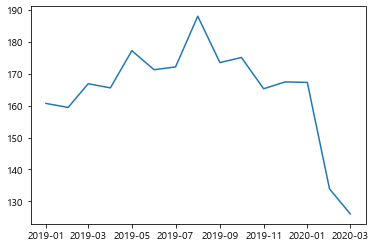

In [100]:
year_count = train.REG_YYMM.value_counts().sort_index()/10000
year_count.index= list(map(lambda x : datetime.datetime.strptime(str(x),"%Y%m"), year_count.index))
sns.lineplot(year_count.index,year_count.values)
plt.show()

In [60]:
print(f'데이터가 가장 많은 날과 개수 : {year_count.idxmax()}, {year_count.max()}')

데이터가 가장 많은 날과 개수 : 2019-08-01 00:00:00, 188.0296


#### 년월별 전체고객의수

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


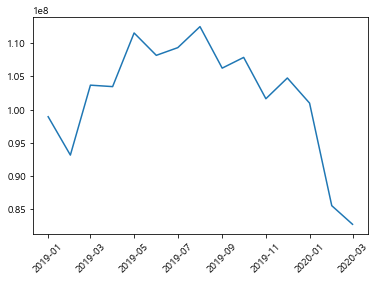

2019-01-01     98934121
2019-02-01     93167173
2019-03-01    103677023
2019-04-01    103458114
2019-05-01    111522559
2019-06-01    108158619
2019-07-01    109315961
2019-08-01    112474554
2019-09-01    106236820
2019-10-01    107848957
2019-11-01    101636818
2019-12-01    104752998
2020-01-01    100977994
2020-02-01     85561518
2020-03-01     82763108
Name: CSTMR_CNT, dtype: int64

In [20]:
check_graph(train, 'REG_YYMM','CSTMR_CNT','line')

#### 년월별 전체 이용금액 
* 2019-02에는 전체이용금액이 감소
* 2019-05, 2020-12에는 전체이용금액이 다소 증가 

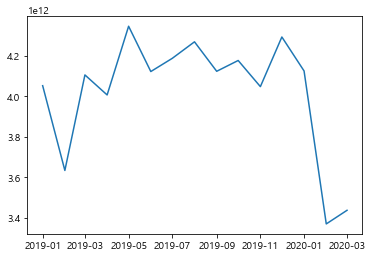

2019-01-01    4052317259025
2019-02-01    3634345832156
2019-03-01    4105409759731
2019-04-01    4006698507386
2019-05-01    4345471235813
2019-06-01    4122105394194
2019-07-01    4187299694709
2019-08-01    4268655968810
2019-09-01    4123348058794
2019-10-01    4176583723584
2019-11-01    4047721898575
2019-12-01    4292549731776
2020-01-01    4124940612820
2020-02-01    3370694945536
2020-03-01    3437884426097
Name: AMT, dtype: int64

In [113]:
check_graph(train, 'REG_YYMM','AMT','line')

#### 년월별 전체 이용건수
* 2019-02에는 전체이용건수이 감소
* 2019-05에는 전체이용건수이 다소 증가 

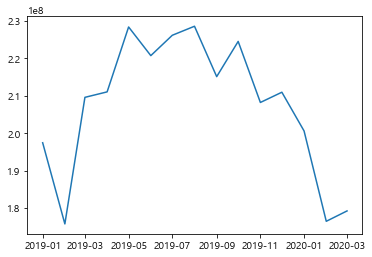

2019-01-01    197458766
2019-02-01    175758111
2019-03-01    209598246
2019-04-01    211060076
2019-05-01    228416675
2019-06-01    220754071
2019-07-01    226194365
2019-08-01    228608721
2019-09-01    215136423
2019-10-01    224550333
2019-11-01    208228088
2019-12-01    210966966
2020-01-01    200612662
2020-02-01    176459558
2020-03-01    179229457
Name: CNT, dtype: int64

In [114]:
check_graph(train, 'REG_YYMM','CNT','line')

In [ ]:
year_people = train.groupby('REG_YYMM')['AMT'].mean()
year_people.index= list(map(lambda x : datetime.datetime.strptime(str(x),"%Y%m"), year_people.index))
sns.lineplot(year_people.index,year_people.values)
plt.show()

### CARD_SIDO_NM 

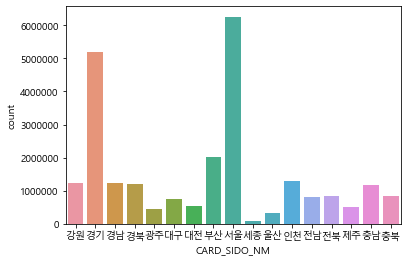

In [115]:
sns.countplot(train.CARD_SIDO_NM)
plt.show()

#### 시도별 이용고객수
* 데이터 개수와 크케 다르지 않음, 강원정도 차이발생

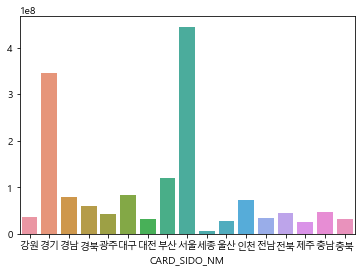

CARD_SIDO_NM
강원     35424111
경기    345133871
경남     78397280
경북     59718037
광주     43127377
대구     83085072
대전     31448075
부산    119843370
서울    444724002
세종      5464559
울산     28116110
인천     72829668
전남     34805715
전북     43902437
제주     24662602
충남     47135876
충북     32668175
Name: CSTMR_CNT, dtype: int64

In [116]:
check_graph(train, 'CARD_SIDO_NM','CSTMR_CNT','bar')

#### 시도별 이용금액
* 경기와 서울이 비슷한 수준으로 나타남

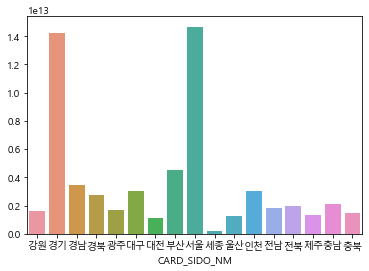

CARD_SIDO_NM
강원     1589611299919
경기    14201885234869
경남     3485130029864
경북     2767620595248
광주     1705650360934
대구     3020064352604
대전     1128913460716
부산     4491306031541
서울    14677131049031
세종      204045817348
울산     1255213605740
인천     3056247462913
전남     1839760777139
전북     1961230185341
제주     1343582224768
충남     2103197375108
충북     1465437185923
Name: AMT, dtype: int64

In [118]:
check_graph(train, 'CARD_SIDO_NM','AMT','bar')

#### 시도별 이용건수 
* 이용건수를 확인하면 경기는 서울대비 건당 매출액이 크다고 추정가능

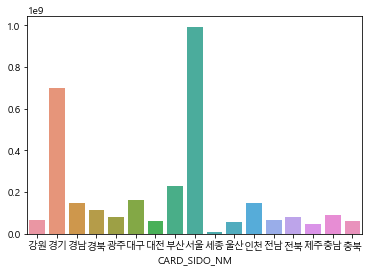

CARD_SIDO_NM
강원     64382529
경기    701143788
경남    149370331
경북    113078004
광주     82758813
대구    164232841
대전     60900956
부산    228178463
서울    994077624
세종     10456634
울산     55429028
인천    147173793
전남     63787592
전북     80723851
제주     45168708
충남     91093453
충북     61076110
Name: CNT, dtype: int64

In [119]:
check_graph(train, 'CARD_SIDO_NM','CNT','bar')

#### 시도별 평균이용금액

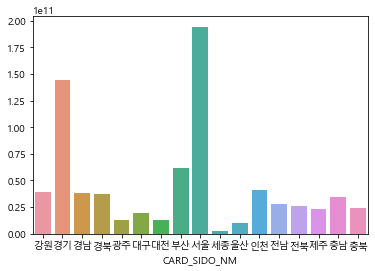

CARD_SIDO_NM
강원    3.932601e+10
경기    1.447135e+11
경남    3.812204e+10
경북    3.745870e+10
광주    1.251556e+10
대구    1.963160e+10
대전    1.253914e+10
부산    6.173433e+10
서울    1.942933e+11
세종    2.178838e+09
울산    1.020410e+10
인천    4.110224e+10
전남    2.781288e+10
전북    2.616786e+10
제주    2.339987e+10
충남    3.437596e+10
충북    2.449881e+10
Name: CNT_per_AMT, dtype: float64

In [123]:
check_graph(train, 'CARD_SIDO_NM','CNT_per_AMT','bar')

### CARD_CCG_NM 
* 상위 15개 시군구
* 중구의 데이터가 가장 많다 

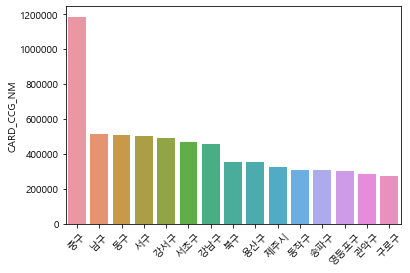

In [8]:
top15 = train.CARD_CCG_NM.value_counts().head(15)

sns.barplot(x = top15.index, y = top15)
plt.xticks(rotation = 45)
plt.show()

#### 시군구별 이용객수
* 서울의 중심부인 중구가 가장 이용객수가 많으며 제주는 15위에 겨우들음

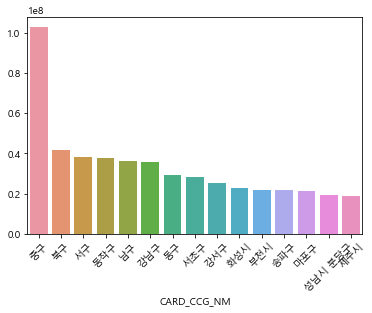

CARD_CCG_NM
중구         102786655
북구          41661072
서구          38322424
동작구         37780912
남구          36405287
강남구         35553738
동구          29144413
서초구         28190688
강서구         25186074
화성시         22892109
부천시         21998798
송파구         21814064
마포구         21232917
성남시 분당구     19163967
제주시         18820667
Name: CSTMR_CNT, dtype: int64

In [21]:
check_graph(train, 'CARD_CCG_NM','CSTMR_CNT','bar',head= 15)

#### 시군구별 이용금액
* 제주시같은경우 금액에서 꽤나 높이 상승함, 관광지기 때문으로 추정됨

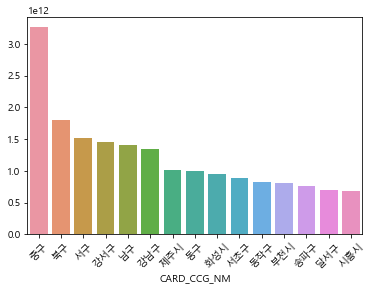

CARD_CCG_NM
중구     3259967804968
북구     1801271706542
서구     1513650168459
강서구    1453144282129
남구     1401412999811
강남구    1349017591977
제주시    1020586774752
동구     1003824081059
화성시     948525028598
서초구     886155256239
동작구     833794388946
부천시     809847360001
송파구     756915712043
달서구     696622071535
시흥시     686323935580
Name: AMT, dtype: int64

In [25]:
check_graph(train, 'CARD_CCG_NM','AMT','bar',head = 15)

#### 시군구별 이용건수

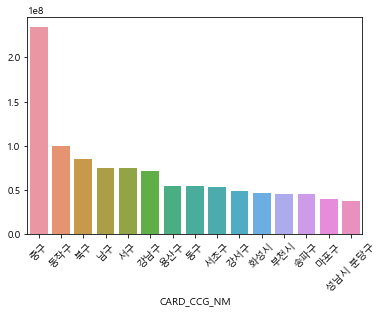

CARD_CCG_NM
중구         234394056
동작구        100121167
북구          84750359
남구          75194142
서구          74738670
강남구         71351496
용산구         53923159
동구          53884886
서초구         52778765
강서구         49181674
화성시         46437104
부천시         45829380
송파구         45060040
마포구         39237239
성남시 분당구     37483345
Name: CNT, dtype: int64

In [26]:
check_graph(train, 'CARD_CCG_NM','CNT','bar',head = 15)

### STD_CLSS_NM 
* 한식음식점, 편의점의 데이터수가 많음 

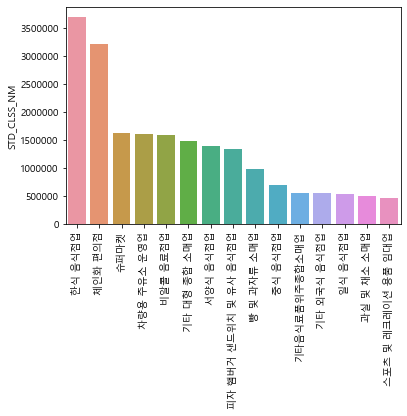

In [79]:
top15 = train.STD_CLSS_NM.value_counts().head(15)
sns.barplot(x = top15.index, y = top15)
plt.xticks(rotation = 90)
plt.show()

#### 업종별 이용금액

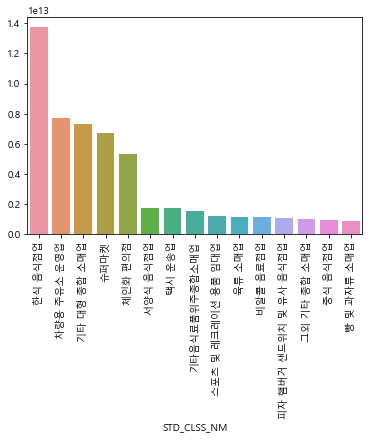

STD_CLSS_NM
한식 음식점업                  13737489719551
차량용 주유소 운영업               7708652073883
기타 대형 종합 소매업              7328854819388
슈퍼마켓                      6730329364274
체인화 편의점                   5303958703193
서양식 음식점업                  1748358904526
택시 운송업                    1733409541974
기타음식료품위주종합소매업             1569246626978
스포츠 및 레크레이션 용품 임대업        1245725426753
육류 소매업                    1166039087386
비알콜 음료점업                  1143497863742
피자 햄버거 샌드위치 및 유사 음식점업     1100581283937
그외 기타 종합 소매업              1025691118171
중식 음식점업                    952361423580
빵 및 과자류 소매업                893591674917
Name: AMT, dtype: int64

In [143]:
plt.xticks(rotation= 90)
check_graph(train, 'STD_CLSS_NM','AMT','bar', head = 15)

### HOM_SIDO_NM  거주지역

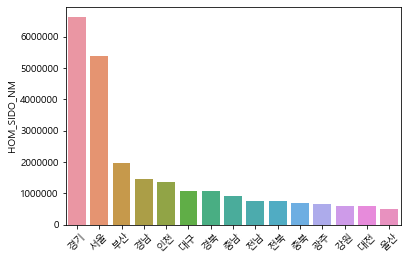

In [10]:
top15 = train.HOM_SIDO_NM.value_counts().head(15)

sns.barplot(x = top15.index, y = top15)
plt.xticks(rotation = 45)
plt.show()

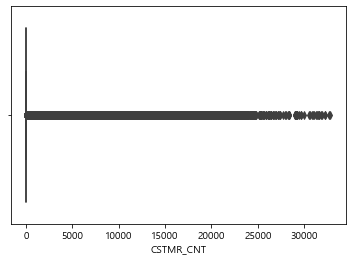

In [90]:
sns.boxplot(train.CSTMR_CNT)